In [14]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from sklearn.metrics import f1_score 
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
from PIL import Image
import os
import re
import csv
import cv2
import math
import numpy as np

In [15]:
plate_cascade = cv2.CascadeClassifier('indian_license_plate.xml')

In [16]:
def detect_plate(img, text=''):
    plate_img = img.copy()
    roi = img.copy()
    plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor=1.2, minNeighbors=7)

    plate = None
    max_plate_area = 0  # Initialize maximum plate area variable before the loop

    for (x, y, w, h) in plate_rect:
        roi_ = roi[y:y+h, x:x+w, :]
        plate_area = w * h

        # Check if the current plate has a larger area than the previous maximum
        if plate_area > max_plate_area:
            max_plate_area = plate_area
            plate = roi[y:y+h, x:x+w, :]
            cv2.rectangle(plate_img, (x+2, y), (x+w-3, y+h-5), (51, 181, 155), 3)

    if text != '' and plate is not None:
        plate_img = cv2.putText(plate_img, text, (x-w//2, y-h//2),
                                cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.5, (51, 181, 155), 1, cv2.LINE_AA)

    return plate_img, plate


def display(img_, title=''):
    # Check if the image is empty
    if img_ is None or img_.size == 0:
        raise ValueError("Error: Image is empty.")
    
    # Convert BGR to RGB (OpenCV uses BGR by default)
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)

    # Display the image using matplotlib
    fig = plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()
    
def remove_salt_and_pepper_noise(noisy_image, kernel_size=3):
    # Use a median filter to remove salt and pepper noise
    denoised_image = cv2.medianBlur(noisy_image, ksize=kernel_size)

    return denoised_image

def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res


def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
#     plt.imshow(img_binary_lp, cmap='gray')
#     plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list


def fix_dimension(img): 
  new_img = np.zeros((96,96,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img
  
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (96,96), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,96,96,3) #preparing image for the model
        y_ = model.predict(img)[0]
        classes_x = np.argmax(y_)
        character = dic[classes_x]
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

def read_first_column(csv_file_path):
    column_items = []
    with open(csv_file_path, 'r') as file:
        csv_reader = csv.reader(file)
        for row in csv_reader:
            # Check if the row has at least one element before accessing the first column
            if row:
                column_items.append(row[0])
            else:
                column_items.append("")  # If the row is empty, append an empty string
    return column_items


In [17]:
model = tf.keras.models.load_model('Model1-25.h5')

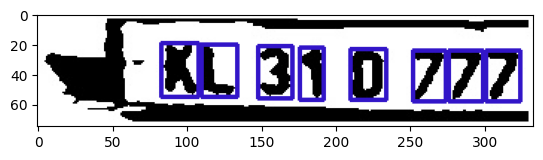

1/1 [==============================] - 0s 69ms/step


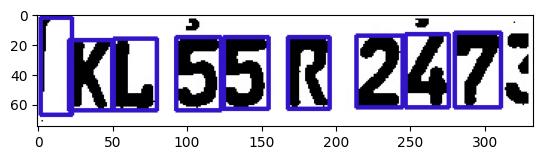

1/1 [==============================] - 0s 76ms/step


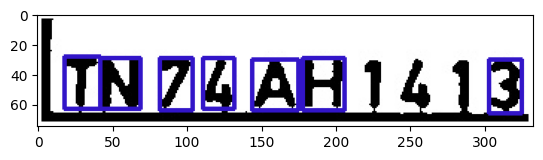

1/1 [==============================] - 0s 76ms/step


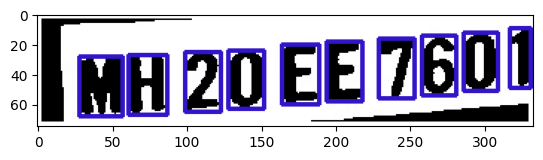

1/1 [==============================] - 0s 59ms/step


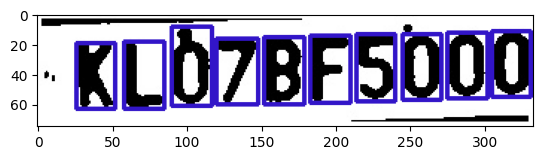

1/1 [==============================] - 0s 77ms/step


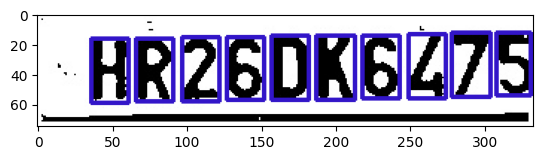

1/1 [==============================] - 0s 75ms/step


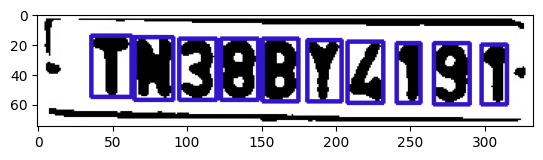

1/1 [==============================] - 0s 73ms/step


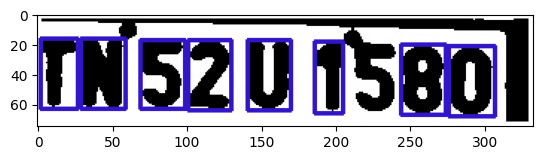

1/1 [==============================] - 0s 74ms/step


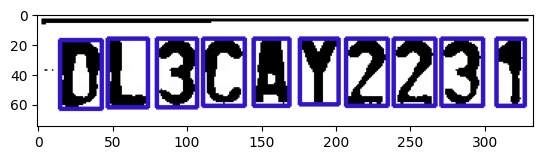

1/1 [==============================] - 0s 80ms/step


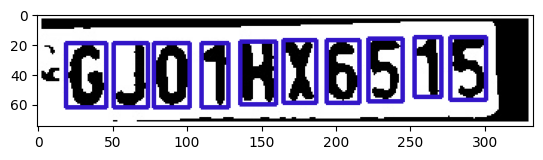

1/1 [==============================] - 0s 77ms/step


In [18]:
input_folder = "images"

image_files = sorted([filename for filename in os.listdir(input_folder) if filename.endswith(('.jpg', '.jpeg', '.png'))], key=natural_sort_key)

predicted = []

for filename in image_files:
    input_path = os.path.join(input_folder, filename)
    img = cv2.imread(input_path)
#     display(img, 'input image')
#     denoised_image = remove_salt_and_pepper_noise(img)
#     img = denoised_image
    output_img, plate = detect_plate(img)
#     if plate is None or plate.size == 0:
#         continue
    char = segment_characters(plate)
    for i in range(len(char)):
        char[i] = 255 - char[i]
    predicted.append(show_results())
    

In [19]:
csv_file_actual = 'Hazy.csv'  # Replace with the path to your CSV file
actual = read_first_column(csv_file_actual)


In [20]:
for plate in actual:
    print(plate)

print(" ")
    
for plate in predicted:
    print(plate)

RJ45CH5898
RJ14CA7406
RJ45CU4154
RJ13CB4334
RJ14UF3853
RJ45CE6928
RJ45CH5898
RJ45CU4154
HR26EM1198
RJ14LC7020
RJ45CQ4036
RJ13CB4334
RJ45CT9496
RJ45CE6928
RJ14CA7406
 
WL31D777
LK455Q241
SN74AH3
NH2DEE76D1
WLT7BF50DD
HQY6DK6475
SNEBB44191
1N52T1BD
DLECAX2231
GJD1HW6515


In [11]:
class IndianNumberPlateResemblance:
    def __init__(self):
        self.resemblance_dict = {}

    def add_resemblance(self, char, resemblances):
        char = char.upper()
        if char not in self.resemblance_dict:
            self.resemblance_dict[char] = set(resemblances)
        else:
            self.resemblance_dict[char].update(resemblances)

    def get_resemblances(self, char):
        char = char.upper()
        return self.resemblance_dict.get(char, {char})

    def is_resemblance(self, char1, char2):
        char1 = char1.upper()
        char2 = char2.upper()
        return char2 in self.resemblance_dict.get(char1, set())

    def calculate_accuracy(self, actual, predicted):
        actual = actual.upper()
        predicted = predicted.upper()

        total_chars = len(actual)
        correct_chars = 0

        for char_actual in actual:
           correct_chars += any(char_pred == char_actual or char_pred in self.get_resemblances(char_actual) for char_pred in predicted)
        
        accuracy = correct_chars / total_chars
        return accuracy

    def calculate_final_accuracy(self, actual_strings, predicted_strings):
        if len(actual_strings) != len(predicted_strings):
            raise ValueError("Number of actual and predicted strings must be the same.")

        total_accuracy = 0

        for actual, predicted in zip(actual_strings, predicted_strings):
            if len(actual) == len(predicted):
                total_accuracy += self.calculate_accuracy(actual, predicted)
            else:
                # print("Handle case where lengths are not equal")
                total_chars = len(actual)
                correct_chars = 0

                for char_actual in actual:
                    # Increment correct_chars if the character or its resemblance is in the predicted string
                    correct_chars += any(char_pred == char_actual or char_pred in self.get_resemblances(char_actual) for char_pred in predicted)
                    
                    
                accuracy = correct_chars / total_chars
                total_accuracy += accuracy

        final_accuracy = total_accuracy / len(actual_strings)
        return final_accuracy

# Example Usage
plate_resemblance = IndianNumberPlateResemblance()

# Adding resemblances
plate_resemblance.add_resemblance('B', ['8', 'E'])
plate_resemblance.add_resemblance('D', ['G', '0', 'O', '9'])
plate_resemblance.add_resemblance('E', ['3'])
plate_resemblance.add_resemblance('3', ['E'])
plate_resemblance.add_resemblance('Q', ['R'])
plate_resemblance.add_resemblance('R', ['Q'])
plate_resemblance.add_resemblance('M', ['K'])
plate_resemblance.add_resemblance('K', ['M', 'W'])
plate_resemblance.add_resemblance('A', ['4'])
plate_resemblance.add_resemblance('1', ['7', 'T'])
plate_resemblance.add_resemblance('8', ['B'])

# Example strings to compare
actual_strings = actual
predicted_strings = predicted

final_accuracy = plate_resemblance.calculate_final_accuracy(actual_strings, predicted_strings)
print("Final Accuracy:", final_accuracy*100)